In [1]:
from utils import constants
from utils.preprocessor import Preprocessor
from pyarabic import araby
from tqdm import tqdm
from utils.combine_docs import combine_CA, combine_MSA
from utils.utils import save_string_to_file, load_string_from_file
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
CA_PATH = r"dataset\Tashkeela-arabic-diacritized-text-utf8-0.3\texts.txt"
MSA_PATH = r"dataset\Tashkeela-arabic-diacritized-text-utf8-0.3\texts.txt\MSA"

In [4]:
combine_CA(CA_PATH, './dataset/v0/CA.txt')

100%|██████████| 97/97 [00:09<00:00, 10.69it/s]


In [5]:
combine_MSA(MSA_PATH, './dataset/v0/MSA.txt')

100%|██████████| 293/293 [00:00<00:00, 2653.51it/s]


In [2]:
with open('./dataset/v0/CA.txt', 'r') as f:
    ca_docs = f.readlines()

In [3]:
with open('./dataset/v0/MSA.txt', 'r') as f:
    msa_docs = f.readlines()

In [4]:
ca_txt = "\n".join(ca_docs)
msa_txt = "\n".join(msa_docs)

In [5]:
ca_txt_ln = len(ca_txt)
msa_txt_ln = len(msa_txt)
print(f"Classical Arabic (CA) size: {ca_txt_ln:,}", f"Modern Standard Arabic (MSA) size: {msa_txt_ln:,}", sep='\n')

Classical Arabic (CA) size: 584,810,861
Modern Standard Arabic (MSA) size: 14,122,305


### Replacing newlines with white spaces and removing extra whitespaces

In [6]:
msa_txt_new = Preprocessor().replace_newline(msa_txt)
msa_txt_new = Preprocessor().collapse_whitespace(msa_txt_new)

In [7]:
ca_txt_new = Preprocessor().replace_newline(ca_txt)
ca_txt_new = Preprocessor().collapse_whitespace(ca_txt_new)

In [8]:
ca_txt_new_ln = len(ca_txt_new)
msa_txt_new_ln = len(msa_txt_new)
print(f"Classical Arabic (CA) new size: {ca_txt_new_ln:,}", f"Modern Standard Arabic (MSA) new size: {msa_txt_new_ln:,}", sep='\n')
print(f"Classical Arabic (CA) #removed characters: {ca_txt_ln - ca_txt_new_ln:,}", f"Modern Standard Arabic (MSA) #removed characters: {msa_txt_ln-msa_txt_new_ln:,}", sep='\n')

Classical Arabic (CA) new size: 582,923,093
Modern Standard Arabic (MSA) new size: 13,920,265
Classical Arabic (CA) #removed characters: 1,887,768
Modern Standard Arabic (MSA) #removed characters: 202,040


### Remove non arabic characters

In [10]:
def remove_non_arabic(text, n_chunks=8):
    # Processing the text as a whole causes high CPU usage,
    # and unexpected behavior causing very high Disk usage (up to 30GB, ) during the process,
    # maybe due to some caching mechansim or something
    # By processing the text in chunks, those problems are mitigated (from ~9min to ~1.5min)
    chunk_size = len(text) // n_chunks
    filtered_chunks = []
    with tqdm(total=len(text), desc='Filtering non-arabic characters', unit='chars') as pbar:
        for i in range(0, len(text), chunk_size):
            chunk = text[i:i+chunk_size]
            filtered_chunk = ''.join([char for char in chunk if char in constants.VALID_ARABIC])
            filtered_chunks.append(filtered_chunk)
            pbar.update(chunk_size)
    
    filtered_text = ''.join(filtered_chunks)
    return filtered_text

In [11]:
msa_txt_clean = remove_non_arabic(msa_txt_new)

Filtering non-arabic characters: 15660297chars [00:02, 7379016.95chars/s]                           


In [12]:
ca_txt_clean = remove_non_arabic(ca_txt_new)

Filtering non-arabic characters:   0%|          | 0/582923093 [00:00<?, ?chars/s]

Filtering non-arabic characters: 655788474chars [01:28, 7451151.15chars/s]                            


In [13]:
ca_txt_clean_ln = len(ca_txt_clean)
msa_txt_clean_ln = len(msa_txt_clean)
print(f"Classical Arabic (CA) new size: {ca_txt_clean_ln:,}", f"Modern Standard Arabic (MSA) new size: {msa_txt_clean_ln:,}", sep='\n')
print(f"Classical Arabic (CA) #removed characters: {ca_txt_new_ln - ca_txt_clean_ln:,}", f"Modern Standard Arabic (MSA) #removed characters: {msa_txt_new_ln-msa_txt_clean_ln:,}", sep='\n')

Classical Arabic (CA) new size: 575,620,372
Modern Standard Arabic (MSA) new size: 13,661,775
Classical Arabic (CA) #removed characters: 7,302,721
Modern Standard Arabic (MSA) #removed characters: 258,490


In [45]:
save_string_to_file(ca_txt_clean, './dataset/v1/CA.txt')
save_string_to_file(msa_txt_clean, './dataset/v1/MSA.txt')

In [49]:
print(f"total number of characters removed in Classical Arabic (CA): {ca_txt_ln - ca_txt_clean_ln:,}")
print(f"total number of characters removed in Modern Standard Arabic (MSA): {msa_txt_ln - msa_txt_clean_ln:,}")

total number of characters removed in Classical Arabic (CA): 9,190,489
total number of characters removed in Modern Standard Arabic (MSA): 460,530


### Splitting

In [28]:
ca_txt = load_string_from_file('./dataset/v1/CA.txt')
msa_txt = load_string_from_file('./dataset/v1/MSA.txt')

In [29]:
print(f"{len(ca_txt):,}", f"{len(msa_txt):,}", sep=' | ')

572,994,271 | 6,845,300


In [30]:
for punc in constants.PUNCTUATIONS:
    ca_txt = ca_txt.replace(punc, '.')
    msa_txt = msa_txt.replace(punc, '.')

In [31]:
ca_split = ca_txt.split(".")
msa_split = msa_txt.split(".")

In [63]:
print(f"Classical Arabic (CA) #sentences: {len(ca_split):,}", f"Modern Standard Arabic (MSA) #sentences: {len(msa_split):,}", sep='\n')

Classical Arabic (CA) #sentences: 7,743,137
Modern Standard Arabic (MSA) #sentences: 258,853


In [88]:
ca_sorted = sorted(ca_split, key=lambda x: len(x.split()))
msa_sorted = sorted(msa_split, key=lambda x: len(x.split()))

In [97]:
import pandas as pd

In [244]:
ca_dfv0 = pd.DataFrame(ca_sorted, columns=['text'])
msa_dfv0 = pd.DataFrame(msa_sorted, columns=['text'])

In [342]:
ca_dfv0['text'] = ca_dfv0['text'].apply(lambda x: x.strip())
msa_dfv0['text'] = msa_dfv0['text'].apply(lambda x: x.strip())

In [343]:
ca_dfv0['words'] = ca_dfv0['text'].apply(lambda x: len(x.split()))
msa_dfv0['words'] = msa_dfv0['text'].apply(lambda x: len(x.split()))

In [344]:
ca_dfv0['chars'] = ca_dfv0['text'].apply(lambda x: len(x))
msa_dfv0['chars'] = msa_dfv0['text'].apply(lambda x: len(x))

In [345]:
ca_dfv0['chars_no_diac'] = ca_dfv0['text'].apply(lambda x: len(araby.strip_diacritics(x)))
msa_dfv0['chars_no_diac'] = msa_dfv0['text'].apply(lambda x: len(araby.strip_diacritics(x)))

In [346]:
ca_dfv0

,text,words,chars,chars_no_diac
0,,0,0,0
1,,0,0,0
2,,0,0,0
3,,0,0,0
4,,0,0,0
...,...,...,...,...
7743132,فَصْلٌ وَقَوْلُهُ صَلَّى اللَّهُ عَلَيْهِ وَسَ...,557,4726,2813
7743133,مَسْأَلَةٌ إِذَا ثَبَتَ ذَلِكَ فَالْوَقْتُ الّ...,597,5277,3144
7743134,قَالَ بَعْضهمْ فِي هَذَا قَوْلَانِ أَحَدهمَا أ...,607,5139,3202
7743135,فَصْلٌ وَقَوْلُهُ فَأَمْلَتْ عَلَيَّ حَافِظُوا...,679,6003,3625


In [347]:
print(f"Classical Arabic (CA) #sentences: {len(ca_dfv0):,}", f"Modern Standard Arabic (MSA) #sentences: {len(msa_dfv0):,}", sep='\n')

Classical Arabic (CA) #sentences: 7,743,137
Modern Standard Arabic (MSA) #sentences: 258,853


In [348]:
ca_dfv1 = ca_dfv0[ca_dfv0['words'] > 3].reset_index(drop=True)
msa_dfv1 = msa_dfv0[msa_dfv0['words'] > 3].reset_index(drop=True)

In [349]:
ca_dfv1

,text,words,chars,chars_no_diac
0,أحكام القرآن لابن العربي,4,24,24
1,وَنَثَرَ فِيهِ أَلْبَابَ الْأَلْبَابِ,4,37,22
2,نَظَرْنَاهَا مِنْ ذَلِكَ الْمَطْرَحِ,4,36,21
3,وَمَا تَعَارَضَ فِيهِ شَجَرْنَاهُ,4,33,20
4,وَنَحْتَاطُ عَلَى جَانِبِ اللُّغَةِ,4,35,21
...,...,...,...,...
4326185,فَصْلٌ وَقَوْلُهُ صَلَّى اللَّهُ عَلَيْهِ وَسَ...,557,4726,2813
4326186,مَسْأَلَةٌ إِذَا ثَبَتَ ذَلِكَ فَالْوَقْتُ الّ...,597,5277,3144
4326187,قَالَ بَعْضهمْ فِي هَذَا قَوْلَانِ أَحَدهمَا أ...,607,5139,3202
4326188,فَصْلٌ وَقَوْلُهُ فَأَمْلَتْ عَلَيَّ حَافِظُوا...,679,6003,3625


In [350]:
print(f"Classical Arabic (CA) #sentences: {len(ca_dfv1):,}", f"Modern Standard Arabic (MSA) #sentences: {len(msa_dfv1):,}", sep='\n')

Classical Arabic (CA) #sentences: 4,326,190
Modern Standard Arabic (MSA) #sentences: 81,677


In [355]:
msa_dfv1.to_csv('./dataset/v2/MSA.csv', index=False, encoding='utf-8')
ca_dfv1.to_csv('./dataset/v2/CA.csv', index=False, encoding='utf-8')

In [356]:
msa_dfv1 = pd.read_csv('./dataset/v2/MSA.csv', encoding='utf-8')
ca_dfv1 = pd.read_csv('./dataset/v2/CA.csv', encoding='utf-8')

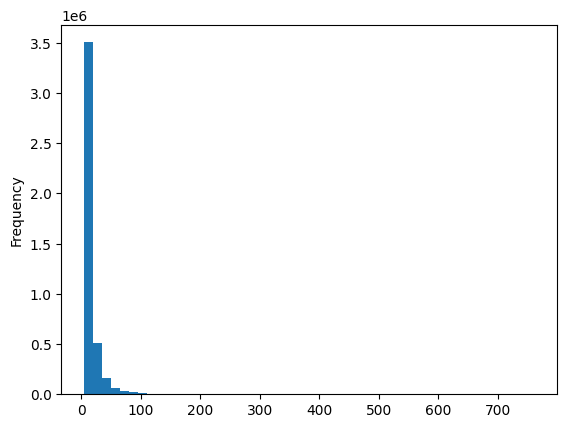

In [357]:
ca_dfv1['words'].plot.hist(bins=50, label='CA');

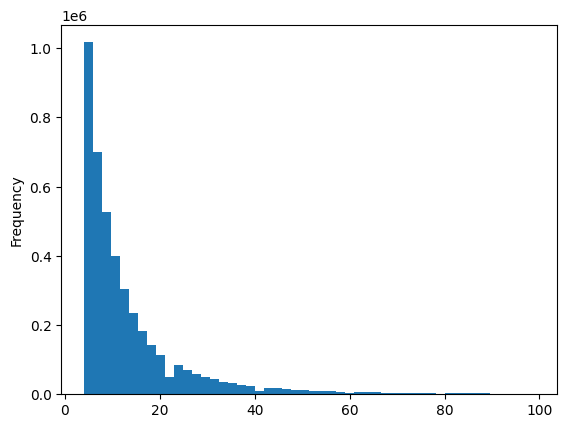

In [358]:
ca_dfv1[ca_dfv1['words']<100]['words'].plot.hist(bins=50, label='CA');

In [370]:
ca_dfv2 = ca_dfv1[(ca_dfv1['words'] > 4) & (ca_dfv1['chars'] >= 47)]
msa_dfv2 = msa_dfv1[(msa_dfv1['words'] > 4) & (msa_dfv1['chars'] >= 47)]

In [371]:
# approximating the avg chars per word in arabic text is 7
# so we can remove any sentence that has less than 7*words characters
# this will remove many of the non-sense sentences
# even if 7 is not the exact avg and is a bit higher, it's rare to eliminate a useful sentence
# sense diacricts are considered as characters thus will ensure to be more than 7 chars per word
ca_clean = ca_dfv2.copy()
for i in range(5, max(ca_dfv2['words'])+1):
    ca_clean = ca_clean[~((ca_clean['words'] > i) & (ca_clean['chars'] < i*7))]
    
msa_clean = msa_dfv2.copy()
for i in range(5, max(msa_dfv2['words'])+1):
    msa_clean = msa_clean[~((msa_clean['words'] > i) & (msa_clean['chars'] < i*7))]

In [372]:
print(f"Classical Arabic (CA) #sentences: {len(ca_clean):,}", f"Modern Standard Arabic (MSA) #sentences: {len(msa_clean):,}", sep='\n')

Classical Arabic (CA) #sentences: 3,225,135
Modern Standard Arabic (MSA) #sentences: 43,897


In [661]:
print(f"total number of sentences removed in Classical Arabic (CA): {len(ca_dfv1) - len(ca_clean):,}")
print(f"total number of sentences removed in Modern Standard Arabic (MSA): {len(msa_dfv1) - len(msa_clean):,}")

total number of sentences removed in Classical Arabic (CA): 1,101,055
total number of sentences removed in Modern Standard Arabic (MSA): 37,780


In [477]:
ca_500 = ca_clean[ca_clean['chars'] <= 500].reset_index(drop=True)
msa_500 = msa_clean[msa_clean['chars'] <= 500].reset_index(drop=True)

In [382]:
print(f"Classical Arabic (CA) #sentences: {len(ca_500):,}", f"Modern Standard Arabic (MSA) #sentences: {len(msa_500):,}", sep='\n')

Classical Arabic (CA) #sentences: 3,117,574
Modern Standard Arabic (MSA) #sentences: 43,835


In [383]:
print(f"total number of sentences removed in Classical Arabic (CA): {len(ca_dfv1) - len(ca_500):,}")
print(f"total number of sentences removed in Modern Standard Arabic (MSA): {len(msa_dfv1) - len(msa_500):,}")

total number of sentences removed in Classical Arabic (CA): 1,208,616
total number of sentences removed in Modern Standard Arabic (MSA): 37,842


In [645]:
def is_fully_diacritized(text):
    text = text+" " # add a space to avoid EOL exception
    ESCAPED = ("ا","ي", "و", "ى", " ", "آ", "إ")
    i = 0
    while i < len(text):
        if text[i] in ESCAPED:
            i += 1
            continue
        if text[i] in constants.HARAKAT:
            if (text[i-1] == constants.SHADDA) or (text[i] == constants.SHADDA and text[i-1] in constants.HARAKAT - set(constants.SHADDA)) or (text[i-1] in ESCAPED):
                i += 1
                continue
            return False # if this reached, then this is a double diacritic on the same character which is totally wrong
        if text[i+1] not in constants.HARAKAT:
            if text[i] == 'ل' and text[i-1] == 'ا':
                i+=1 # skip the (ال)
                continue
            # print(f"Character {text[i]} at index {i} is not diacritized")
            return False
        i += 2
    return True
        

In [646]:
is_fully_diacritized("وَتُنْسَبُ إلَيْهِ فِيهِ الْمَقَادِيرُ وَالْكَائِنَاتُ")

True

In [657]:
msa_500.shape, ca_500.shape

(43835, 4)

In [658]:
msa_fully_diac = msa_500[msa_500['text'].apply(is_fully_diacritized)]
ca_fully_diac = ca_500[ca_500['text'].apply(is_fully_diacritized)]

In [659]:
print(f"Classical Arabic (CA) #sentences: {len(ca_fully_diac):,}", f"Modern Standard Arabic (MSA) #sentences: {len(msa_fully_diac):,}", sep='\n')

Classical Arabic (CA) #sentences: 2,628,203
Modern Standard Arabic (MSA) #sentences: 29,706


In [660]:
print(f"total number of sentences removed in Classical Arabic (CA): {len(ca_500) - len(ca_fully_diac):,}")
print(f"total number of sentences removed in Modern Standard Arabic (MSA): {len(msa_500) - len(msa_fully_diac):,}")

total number of sentences removed in Classical Arabic (CA): 489,371
total number of sentences removed in Modern Standard Arabic (MSA): 14,129


In [677]:
ca_fully_diac.to_csv('./dataset/v3/CA.csv', index=False, encoding='utf-8')
msa_fully_diac.to_csv('./dataset/v3/MSA.csv', index=False, encoding='utf-8')

In [4]:
ca_ds = pd.read_csv('./dataset/v3/CA.csv')
msa_ds = pd.read_csv('./dataset/v3/MSA.csv')

In [20]:
from sklearn.model_selection import train_test_split

In [45]:
msa_ds['chars'].describe()

(5.387995246305006, 5.016840166376898)

In [141]:
msa_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 48, float("inf")]

In [142]:
ca_cut = pd.cut(ca_ds['words'], 15)
msa_cut = pd.cut(msa_ds['words'], msa_bins)

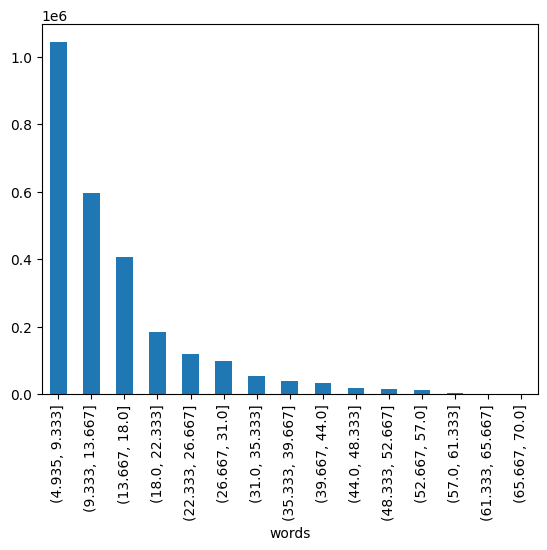

In [144]:
ca_cut.value_counts().sort_index().plot.bar();

In [92]:
msa_ds

,text,words,chars,chars_no_diac
0,فَكَانَتْ تَسْمَعُ امْرَأَةٌ اسْمُهَا لِيدِيَّةُ,5,48,28
1,بَيَّاعَةُ أُرْجُوَانٍ مِنْ مَدِينَةِ ثَيَاتِيرَا,5,49,29
2,فَانْفَتَحَتْ فِي الْحَالِ الأَبْوَابُ كُلُّهَا,5,47,29
3,فَاخْتَشَوْا لَمَّا سَمِعُوا أَنَّهُمَا رُومَا...,5,54,32
4,وَسَأَلُوهُمَا أَنْ يَخْرُجَا مِنَ الْمَدِينَةِ,5,47,28
...,...,...,...,...
29701,وَهُوَ اللَّهُ لَا إِلَهَ إِلَّا هُوَ لَهُ الْ...,56,475,283
29702,وَإِذْ قَالَ رَبُّكَ لِلْمَلَائِكَةِ إِنِّي جَ...,56,485,290
29703,وَأَنَّ الْعَلَاقَةَ الْجِنْسِيَّةَ هِيَ نَجَس...,56,498,288
29704,وَقَالُوا لَنْ نُؤْمِنَ لَكَ حَتَّى تَفْجُرَ ل...,59,479,285


In [151]:
msa_train, temp, _, st_y = train_test_split(msa_ds, msa_cut, stratify=msa_cut, test_size=0.1, random_state=2024)
msa_val, msa_test = train_test_split(temp, stratify=st_y, test_size=0.5, random_state=42)

In [152]:
ca_train, temp, _, st_y = train_test_split(ca_ds, ca_cut, stratify=ca_cut, test_size=0.1, random_state=2024)
ca_val, ca_test = train_test_split(temp, stratify=st_y, test_size=0.5, random_state=42)

In [163]:
print(f"CA train: {len(ca_train):,}", f"CA val: {len(ca_val):,}", f"CA test: {len(ca_test):,}",sep='\n')

CA train: 2,365,382
CA val: 131,410
CA test: 131,411


In [162]:
print(f"MSA train: {len(msa_train):,}", f"MSA val: {len(msa_val):,}", f"MSA test: {len(msa_test):,}",sep='\n')

MSA train: 26,735
MSA val: 1,485
MSA test: 1,486


In [164]:
ca_train.to_csv('./dataset/Tashkeela-clean/CA/CA_train.csv', index=False, encoding='utf-8')
ca_val.to_csv('./dataset/Tashkeela-clean/CA/CA_val.csv', index=False, encoding='utf-8')
ca_test.to_csv('./dataset/Tashkeela-clean/CA/CA_test.csv', index=False, encoding='utf-8')

In [165]:
msa_train.to_csv('./dataset/Tashkeela-clean/MSA/MSA_train.csv', index=False, encoding='utf-8')
msa_val.to_csv('./dataset/Tashkeela-clean/MSA/MSA_val.csv', index=False, encoding='utf-8')
msa_test.to_csv('./dataset/Tashkeela-clean/MSA/MSA_test.csv', index=False, encoding='utf-8')

In [ ]:
ca_train, ca_val, ca_test = pd.read_csv('./dataset/Tashkeela-clean/CA/CA_train.csv'), pd.read_csv('./dataset/Tashkeela-clean/CA/CA_val.csv'), pd.read_csv('./dataset/Tashkeela-clean/CA/CA_test.csv')
msa_train, msa_val, msa_test = pd.read_csv('./dataset/Tashkeela-clean/MSA/MSA_train.csv'), pd.read_csv('./dataset/Tashkeela-clean/MSA/MSA_val.csv'), pd.read_csv('./dataset/Tashkeela-clean/MSA/MSA_test.csv')

In [ ]:
def fix_shadda(text):
    def _swap(text, i, j):
        text = list(text)
        text[i], text[j] = text[j], text[i]
        return ''.join(text)

    text = text+" " # add space to avoid index out of range
    idx = 0
    while idx < len(text)-1:
        curr, next = text[idx], text[idx+1]
        if curr in constants.HARAKAT and next == constants.SHADDA:
            text = _swap(text, idx, idx+1)
        idx += 1
    return text[:-1]

In [ ]:
ca_train.text = ca_train.text.apply(Preprocessor.fix_shadda)
ca_val.text = ca_val.text.apply(Preprocessor.fix_shadda)
ca_test.text = ca_test.text.apply(Preprocessor.fix_shadda)

msa_train.text = msa_train.text.apply(Preprocessor.fix_shadda)
msa_val.text = msa_val.text.apply(Preprocessor.fix_shadda)
msa_test.text = msa_test.text.apply(Preprocessor.fix_shadda)

In [40]:
def has_consecutive_diacritics(text):
    text = text+' ' # add space to avoid index out of range
    idx = 0
    while idx < len(text)-1:
        # if the current character is a diacritic and the next character is a diacritic or if the current character is shadda and the next character is shadda
        if (text[idx] in (constants.HARAKAT - set(constants.SHADDA)) and text[idx+1] in constants.HARAKAT) or (text[idx] == constants.SHADDA and text[idx+1] == constants.SHADDA):
            return True
        idx += 1
    return False

def has_space_diac(text):
    text = text+' ' # add space to avoid index out of range
    idx = 0
    while idx<len(text)-1:
        if text[idx] in " " and text[idx+1] in constants.HARAKAT:
            return True
        idx += 1
    return False

def fix_diacritic_start(text):
    while text[0] in constants.HARAKAT:
        text = text[1:].strip()
    return text

In [41]:
msa_train_fix1 = msa_train[~msa_train['text'].apply(has_consecutive_diacritics)]
msa_val_fix1 = msa_val[~msa_val['text'].apply(has_consecutive_diacritics)]
msa_test_fix1 = msa_test[~msa_test['text'].apply(has_consecutive_diacritics)]

In [42]:
ca_train_fix1 = ca_train[~ca_train['text'].apply(has_consecutive_diacritics)]
ca_val_fix1 = ca_val[~ca_val['text'].apply(has_consecutive_diacritics)]
ca_test_fix1 = ca_test[~ca_test['text'].apply(has_consecutive_diacritics)]

In [43]:
msa_train_fix2 = msa_train_fix1[~msa_train_fix1['text'].apply(has_space_diac)]
msa_val_fix2 = msa_val_fix1[~msa_val_fix1['text'].apply(has_space_diac)]
msa_test_fix2 = msa_test_fix1[~msa_test_fix1['text'].apply(has_space_diac)]

In [44]:
ca_train_fix2 = ca_train_fix1[~ca_train_fix1['text'].apply(has_space_diac)]
ca_val_fix2 = ca_val_fix1[~ca_val_fix1['text'].apply(has_space_diac)]
ca_test_fix2 = ca_test_fix1[~ca_test_fix1['text'].apply(has_space_diac)]

In [45]:
msa_train_fix3 = msa_train_fix2.copy()
msa_val_fix3 = msa_val_fix2.copy()
msa_test_fix3 = msa_test_fix2.copy()

msa_train_fix3['text'] = msa_train_fix3['text'].apply(fix_diacritic_start)
msa_val_fix3['text'] = msa_val_fix3['text'].apply(fix_diacritic_start)
msa_test_fix3['text'] = msa_test_fix3['text'].apply(fix_diacritic_start)

In [46]:
ca_train_fix3 = ca_train_fix2.copy()
ca_val_fix3 = ca_val_fix2.copy()
ca_test_fix3 = ca_test_fix2.copy()

ca_train_fix3['text'] = ca_train_fix3['text'].apply(fix_diacritic_start)
ca_val_fix3['text'] = ca_val_fix3['text'].apply(fix_diacritic_start)
ca_test_fix3['text'] = ca_test_fix3['text'].apply(fix_diacritic_start)

In [48]:
msa_train_fix3.to_csv('./dataset/Tashkeela-clean-V2.0/MSA/MSA_train.csv', index=False, encoding='utf-8')
msa_val_fix3.to_csv('./dataset/Tashkeela-clean-V2.0/MSA/MSA_val.csv', index=False, encoding='utf-8')
msa_test_fix3.to_csv('./dataset/Tashkeela-clean-V2.0/MSA/MSA_test.csv', index=False, encoding='utf-8')

ca_train_fix3.to_csv('./dataset/Tashkeela-clean-V2.0/CA/CA_train.csv', index=False, encoding='utf-8')
ca_val_fix3.to_csv('./dataset/Tashkeela-clean-V2.0/CA/CA_val.csv', index=False, encoding='utf-8')
ca_test_fix3.to_csv('./dataset/Tashkeela-clean-V2.0/CA/CA_test.csv', index=False, encoding='utf-8')

In [47]:
print(f"Number of sentences removed in Classical Arabic (CA): {len(ca_train) - len(ca_train_fix2):,}")
print(f"Number of sentences removed in Modern Standard Arabic (MSA): {len(msa_train) - len(msa_train_fix2):,}")

Number of sentences removed in Classical Arabic (CA): 304
Number of sentences removed in Modern Standard Arabic (MSA): 8
